In [1]:
import os

In [2]:
computation = 'cloud'

In [3]:
if computation == 'local':
  data_path = '../data/transaction_fraud/'
  global_model_path = '../models/globalmodel'
  ensemble_model_path = '../models/ensemblemodel_2'
  lof_database_path = '../models/lof_database'
  data_preprocess_path = '../data/data_preprocess'
  customer_frequency_rating_path = '../models/customer_fr_database'
  merchant_frequency_rating_path = '../models/merchant_fr_database'
else :
  !pip install river
  !pip install imbalanced-learn
  !pip install xgboost
  from google.colab import drive
  drive.mount('/content/drive')
  data_path = '/content/drive/MyDrive/uco_fraud_detector/data/transaction_fraud/'
  global_model_path = '/content/drive/MyDrive/uco_fraud_detector/models/globalmodel'
  ensemble_model_path = '/content/drive/MyDrive/uco_fraud_detector/models/ensemblemodel_2'
  lof_database_path = '/content/drive/MyDrive/uco_fraud_detector/models/lof_database'
  customer_frequency_rating_path = '/content/drive/MyDrive/uco_fraud_detector/models/customer_fr_database'
  merchant_frequency_rating_path = '/content/drive/MyDrive/uco_fraud_detector/models/merchant_fr_database'
  data_preprocess_path = '/content/drive/MyDrive/uco_fraud_detector/data/data_preprocess'

print(f'Searching for file : ',{'found' if os.path.exists(data_path) else 'not found'})
print(os.listdir(data_path))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 94.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
Mounted at /content/drive
Searching for file :  {'found'}
['bs140513_032310.csv', 'bsNET140513_032310.csv']


In [4]:
data_path = data_path + os.listdir(data_path)[0]

In [5]:
print("searching data file : " , 'found' if os.path.exists(data_path) else 'not found')
print("searching global model : " , 'found' if os.path.exists(global_model_path) else 'not found')
print("searching ensemble model : " , 'found' if os.path.exists(ensemble_model_path) else 'not found')
print("searching lof database : " , 'found' if os.path.exists(lof_database_path) else 'not found')

searching data file :  found
searching global model :  found
searching ensemble model :  found
searching lof database :  found


In [6]:
import pandas as pd
import numpy as np

In [7]:
df = pd.read_csv(data_path)

In [8]:
# import pickle
# global_model = pickle.load(open(global_model_path,'rb'))
# ensemble_model = pickle.load(open(ensemble_model_path,'rb'))
# lof_database = pickle.load(open(lof_database_path,'rb'))
# data_preprocess = pickle.load(open(data_preprocess_path,'rb'))

basic preprocessing

In [9]:
for c in df.columns :
    if df[c].dtype==object :
        df[c] = df[c].replace("'","", regex = True)
df = df.drop(columns = ['zipcodeOri','zipMerchant'], axis = 1)

df.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0


In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pickle
import os
import io

class FraudDetector :
  def __init__(self,
           global_model_path,
           lof_database_path,
           customer_frequency_rating_path,
           merchant_frequency_rating_path,
           ensemble_model_path,
           ) :
    self.global_model = pickle.load(open(global_model_path,'rb'))
    self.ensemble_model = pickle.load(open(ensemble_model_path,'rb'))
    self.lof_database = pickle.load(open(lof_database_path,'rb'))
    self.data_preprocess = pickle.load(open(data_preprocess_path,'rb'))
    self.customer_frequency_rating = self.data_preprocess['customer_frequency_rating_encoder']
    self.merchant_frequency_rating = self.data_preprocess['merchant_frequency_rating_encoder']
    self.input_index = self.lof_database['feeded_index'] + 1

  def general_preprocess(self , data) :
    account_id = data['customer']
    data['customer'] = self.customer_frequency_rating[account_id]
    merchant_id = data['merchant']
    data['merchant'] = self.merchant_frequency_rating[merchant_id]
    for c in self.global_model.categorical_features :
      data[c] = self.global_model.label_encoders[c].transform([data[c]])[0]
    merchant_id = self.lof_database['merchant_label_encoder'].transform([merchant_id])[0]
    return account_id , merchant_id , data

  def global_preprocess(self , account_id , merchant_id , data) :
    return np.array([data['step'] ,
                    data['customer'] ,
                    data['age'] ,
                    data['merchant'],
                    data['gender'] ,
                    data['category'] ,
                    data['amount']],
                    dtype = float).reshape(1,-1)

  def lof_preprocess(self , account_id , merchant_id , data) :
    return {
        'merchant_id' : merchant_id,
        'category' : data['category'],
        'amount' : data['amount']}

  def ensemble_preprocess(self , g_output_fraud , lof_score , data) :
    amount = data['amount']
    amount = self.ensemble_model.amount_scaler.transform([[amount]])[0]
    cat = data['category']
    return np.array([cat,
                     amount[0],
                     g_output_fraud,
                     lof_score],
                    dtype=float).reshape(1,-1)

  def plot_lof_graph(self , account_id : str , data4lof : dict , image_buffer = None) :
    merchant_id = data4lof['merchant_id']
    category = data4lof['category']
    amount = data4lof['amount']
    data_df = pd.DataFrame(self.lof_database[account_id].x_list)
    data_df.columns = ['merchant_id' , 'category' , 'amount']
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')
    ax.scatter3D(data_df['merchant_id'], data_df['category'], data_df['amount'] , alpha = 0.3)
    ax.scatter3D(merchant_id, category, amount, color = 'red' ,s = 100,  alpha = 1)
    ax.set_xlabel('merchant_id')
    ax.set_ylabel('category')
    ax.set_zlabel('amount')
    ax.set_title(f'LOF Database for {account_id}')
    plt.show()
    # plt.savefig(image_buffer , format = 'png')
    # plt.close()
    # return image_buffer


  def predict_one(self , data , learn = True, get_log = False) :
    # text_buffer = None
    # image_buffer = None
    if(get_log) :
      # text_buffer = io.StringIO()
      # np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=4, suppress=True)
      print(f"input data : \n{data}\n")# text_buffer.write

    time_start = dt.datetime.now()
    account_id , merchant_id , data = self.general_preprocess(data)
    data4global = self.global_preprocess(account_id , merchant_id , data)
    data4lof = self.lof_preprocess(account_id , merchant_id , data)
    if('fraud' in data.index) :
      isfraud = data['fraud']
    else :
      isfraud = None

    # prediction
    global_predict_proba = self.global_model.predict_proba(data4global)
    g_output_fraud = global_predict_proba[0][1]
    lof_score = self.lof_database[account_id].score_one(data4lof)
    data4ensemble = self.ensemble_preprocess(g_output_fraud , lof_score , data)
    ensemble_output = self.ensemble_model.predict(data4ensemble)[0]
    prediction = ensemble_output
    if learn and (isfraud == 0 or prediction == 0) :
       self.lof_database[account_id].learn_one(data4lof)
    time_end = dt.datetime.now( )
    inference_time = (time_end - time_start).total_seconds()
    if get_log :
      # image_buffer = io.BytesIO()
      print(f"data4global : \n{data4global}\n")# text_buffer.write
      print(f"data4ensemble : \n{data4ensemble}\n")# text_buffer.write
      print(f"data4lof : \n{data4lof}\n")# text_buffer.write
      print(f"g_fraud_probability : {g_output_fraud:.6f}\n")# text_buffer.write
      print(f"lof_score : {lof_score:.4f}\n")# text_buffer.write
      print(f"ensemble_output : {ensemble_output}\n")# text_buffer.write
      if isfraud != None :
        print(f"true_fraud : {isfraud}\n")# text_buffer.write
      print(f"inference_time : {inference_time:.4f} seconds\n")# text_buffer.write
      # text_buffer.seek(0)
      self.plot_lof_graph(account_id , data4lof , None)
      # image_buffer.seek(0)
    return g_output_fraud , lof_score , prediction


In [12]:
ob = FraudDetector(global_model_path,
                   lof_database_path,
                   customer_frequency_rating_path,
                   merchant_frequency_rating_path,
                   ensemble_model_path)

input data : 
step                      168
customer          C1394931354
age                         4
gender                      M
merchant          M1823072687
category    es_transportation
amount                  47.06
fraud                       0
Name: 550404, dtype: object

data4global : 
[[1.68000e+02 1.76000e+02 4.00000e+00 2.99693e+05 2.00000e+00 1.20000e+01
  4.70600e+01]]

data4ensemble : 
[[12.          0.08849135  0.29303384  1.0343102 ]]

data4lof : 
{'merchant_id': np.int64(18), 'category': np.int64(12), 'amount': np.float64(47.06)}

g_fraud_probability : 0.293034

lof_score : 1.0343

ensemble_output : 1

true_fraud : 0

inference_time : 0.0755 seconds



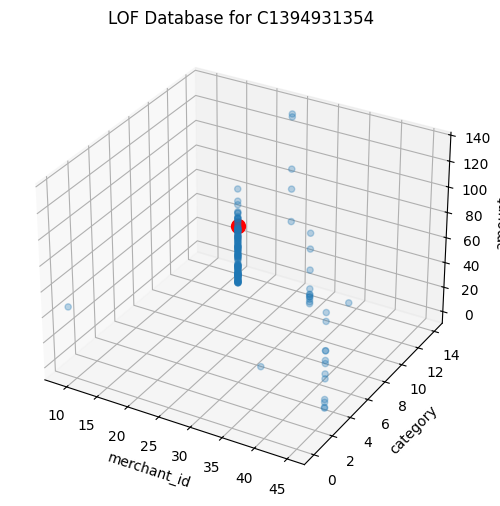

(np.float32(0.29303384), np.float64(1.0343102000287026), np.int64(1))

In [15]:
ob.predict_one(df.iloc[550406] ,learn=False, get_log = True)

## creating contrast data

KeyboardInterrupt: 

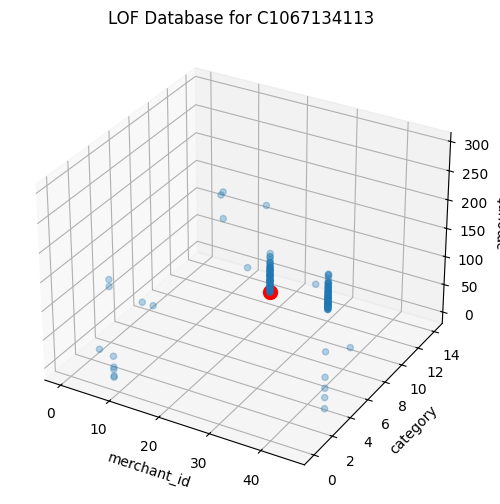

In [ ]:
import io
i = 505445
gless5_image_buffers = []
lofless1_image_buffers = []
matchpred_image_buffers = []
gless5_text_buffers = []
lofless1_text_buffers = []
matchpred_text_buffers = []
required_size = 20
while i < df.shape[0] and (len(matchpred_image_buffers) <= 100) :
  y_true = df.iloc[i]['fraud']
  account_id = df.iloc[i]['customer']
  g_output_fraud , lof_score , prediction , text_buffer, image_buffer  = ob.predict_one(df.iloc[i] ,learn=True, get_log = True)
  if prediction == 1 and y_true == 1 :
    if g_output_fraud <= 0.5 :
      gless5_text_buffers.append(text_buffer)
      gless5_image_buffers.append(image_buffer)
    if lof_score <= 1 :
      lofless1_text_buffers.append(text_buffer)
      lofless1_image_buffers.append(image_buffer)

    matchpred_text_buffers.append(text_buffer)
    matchpred_image_buffers.append(image_buffer)
  i += 1


In [ ]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=e87ea62127e78652aff54aa6f6008df5efb2ed95a4f0678a2c6ae82e97bd79f4
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [ ]:
from fpdf import FPDF
import tempfile
from PIL import Image

global_contrast_pdf = FPDF()
for a in range(len(gless5_image_buffers)) :
  global_contrast_pdf.add_page()
  global_contrast_pdf.set_font('Arial',size = 10)

  # Save the image to a temporary file
  with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp_file:
      tmp_file.write(gless5_image_buffers[a].getvalue())
      tmp_file_path = tmp_file.name

  # Get image dimensions using Pillow
  img = Image.open(tmp_file_path)
  image_width, image_height = img.size
  img.close()

  # Decrease the width of the image
  new_image_width_mm = 150
  global_contrast_pdf.image(tmp_file_path , x = 10 , y = 10 , w = new_image_width_mm)

  # Remove the temporary file after use
  os.remove(tmp_file_path)

  # Set the cursor position for the text below the image.
  # We need to calculate the scaled height in mm based on the new width.
  scaled_image_height_mm = (image_height / image_width) * new_image_width_mm


  global_contrast_pdf.set_xy(10, 10 + scaled_image_height_mm + 5) # 5 is for some padding

  gless5_text_buffers[a].seek(0)
  global_contrast_pdf.multi_cell(w = 190 , h = 5 , txt = gless5_text_buffers[a].read() , align = 'L')

global_contrast_pdf.output('global_contrast.pdf')
print("saved pdf")

saved pdf


In [ ]:
#free up the buffers
for a in range(len(gless5_image_buffers)) :
  gless5_image_buffers[a].close()
  gless5_text_buffers[a].close()
for a in range(len(lofless1_image_buffers)) :
  lofless1_image_buffers[a].close()
  lofless1_text_buffers[a].close()
for a in range(len(matchpred_image_buffers)) :
  matchpred_image_buffers[a].close()
  matchpred_text_buffers[a].close()